# Polynomial Regression

##  MSE Loss

In [1]:
from sklearn.preprocessing import PolynomialFeatures #allowed - Piazza
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('./weather_data.xlsx').values
print(type(data), data.shape)
print(data[:5,:])

<class 'numpy.ndarray'> (1000, 7)
[[  28   59   20 1008    0    0   20]
 [  48   61   10 1012    1    0   21]
 [  24   53    3 1001    0    0   16]
 [  17   54    8 1002    0    0   16]
 [  27   51    5 1007    0    0   14]]


In [3]:
train_data=data[:700,:].astype('float64')
TEST_data=data[700:,:].astype('float64')

mean = train_data[:,:-1].mean(axis=0,keepdims=True)
stddev = train_data[:,:-1].std(axis=0,keepdims=True)
print("mean",mean)
print("stddev",stddev)

train_data[:,:-1]-=mean
train_data[:,:-1]/=stddev
TEST_data[:,:-1]-=mean
TEST_data[:,:-1]/=stddev

Cross_Validation_data=np.array_split(train_data,5)
print(len(Cross_Validation_data))

X_TEST,y_TEST = TEST_data[:,:-1],TEST_data[:,-1:]
print(X_TEST.shape, y_TEST.shape)

mean [[2.93814286e+01 4.92828571e+01 1.26957143e+01 1.00992143e+03
  3.00000000e-01 2.55714286e-01]]
stddev [[12.44055342 14.60205437  4.70564815  5.07214784  0.45825757  0.43626195]]
5
(300, 6) (300, 1)


### bias variance without regularisation

#### Inferences - 
1. as the dimension of transformed space increases, we get overfitting
2. weights in higher dimension are higher in magnitude (i.e. w takes big values to overfit)

In [39]:
def mse_loss(Y_true,Y_pred):
    return ((Y_true-Y_pred)**2).mean()

def Get_W_NoReg(X,y):
    return (np.linalg.pinv(X.T.dot(X))).dot(X.T).dot(y)

In [22]:
#cross validate
def cross_validate(Cross_Validation_data, n):
    train_error_CV, test_error_CV = [],[]
#     print("train size %u, val size %u"%(train_data.shape[0]-Cross_Validation_data[0].shape[0],Cross_Validation_data[0].shape[0]) )
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]
        
        Phi_X = poly.fit_transform(X_train)
        Phi_Xt = poly.fit_transform(X_test)
        
        w = Get_W_NoReg(Phi_X,y_train)

        y_pred_train = Phi_X.dot(w)
        y_pred_test = Phi_Xt.dot(w)

        train_error_CV.append(mse_loss(y_train, y_pred_train))
        test_error_CV.append(mse_loss(y_test, y_pred_test))

    n_cv = len(train_error_CV)
    train_error, test_error = sum(train_error_CV)/n_cv, sum(test_error_CV)/n_cv
    return train_error, test_error

In [23]:
train_ERROR, val_ERRROR, TEST_ERROR = [],[],[]
degrees=np.array([1,2,3,4,5])
for n in degrees:
    poly=PolynomialFeatures(n)
    train_error, val_error = cross_validate(Cross_Validation_data,n)
    
    Phi_X = poly.fit_transform(train_data[:,:-1])
    Phi_XTEST = poly.fit_transform(TEST_data[:,:-1])
    w = Get_W_NoReg(Phi_X, train_data[:,-1:])
    y_pred_TEST = Phi_XTEST.dot(w)
    TEST_error = mse_loss(TEST_data[:,-1], y_pred_TEST[:,0])

    train_ERROR.append(train_error)
    val_ERRROR.append(val_error)
    TEST_ERROR.append(TEST_error)
    
    print('degree %u has %u coefficient weights'%(n,Phi_X.shape[1]))

degree 1 has 7 coefficient weights
degree 2 has 28 coefficient weights
degree 3 has 84 coefficient weights
degree 4 has 210 coefficient weights
degree 5 has 462 coefficient weights


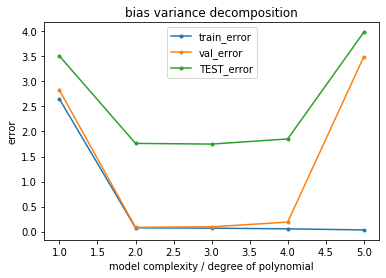

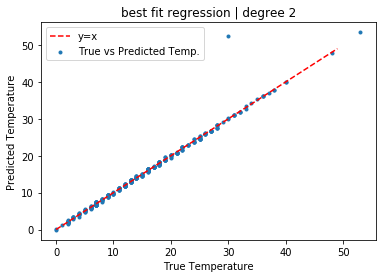

In [9]:
plt.title('bias variance decomposition')
plt.xlabel('model complexity / degree of polynomial')
plt.ylabel('error')
plt.plot(degrees, train_ERROR, label='train_error',marker='.')
plt.plot(degrees, val_ERRROR, label='val_error',marker='.')
plt.plot(degrees, TEST_ERROR, label='TEST_error',marker='.')
plt.legend()
plt.savefig('PolynomialRegression.png')
plt.show()

poly=PolynomialFeatures(2)
Phi_X = poly.fit_transform(train_data[:,:-1])
Phi_XTEST = poly.fit_transform(TEST_data[:,:-1])
w = Get_W_NoReg(Phi_X, train_data[:,-1:])
y_pred_TEST = Phi_XTEST.dot(w)
plt.title('best fit regression | degree 2')
plt.scatter(y_TEST, y_pred_TEST,label='True vs Predicted Temp.',marker='.')
a=np.arange(0,50,1)
plt.plot(a,a,label='y=x',color='r',linestyle='dashed')
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.legend()
plt.savefig('PolynomialRegression2.png')
plt.show()

### 3.1.2 Regularizing the polynomial regression model to see change in train & test error

#### Inferences - 
1. as we increase regularisation in overfitting regime, the train error inc and test error dec
2. also the weights of higher order terms reduce to zero

In [29]:
# L2 regularisation
def Get_W_L2_Reg(X,y,alpha):
    return (np.linalg.pinv(X.T.dot(X) + alpha*np.identity(X.shape[1]))).dot(X.T).dot(y)

#cross validate
def cross_validate(Cross_Validation_data, n, alpha):
    train_error_CV, test_error_CV = [],[]
#     print("train size %u, val size %u"%(train_data.shape[0]-Cross_Validation_data[0].shape[0],Cross_Validation_data[0].shape[0]) )
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]
        
        Phi_X = poly.fit_transform(X_train)
        Phi_Xt = poly.fit_transform(X_test)
        
        w = Get_W_L2_Reg(Phi_X,y_train,alpha)

        y_pred_train = Phi_X.dot(w)
        y_pred_test = Phi_Xt.dot(w)

        train_error_CV.append(mse_loss(y_train, y_pred_train))
        test_error_CV.append(mse_loss(y_test, y_pred_test))

    n_cv = len(train_error_CV)
    train_error, test_error = sum(train_error_CV)/n_cv, sum(test_error_CV)/n_cv
    return train_error, test_error

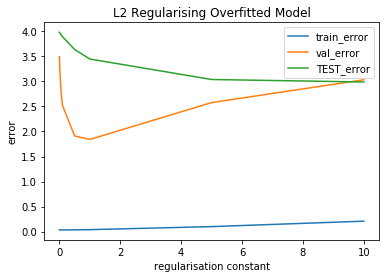

In [30]:
Ws=[]
train_ERROR, val_ERRROR, TEST_ERROR = [],[],[]
alphas = [0,0.01,0.05,0.1,0.5,1,5,10]
poly=PolynomialFeatures(5)
for alpha in alphas:
    train_error, val_error = cross_validate(Cross_Validation_data,n,alpha)
    
    Phi_X = poly.fit_transform(train_data[:,:-1])
    Phi_XTEST = poly.fit_transform(TEST_data[:,:-1])
    w = Get_W_L2_Reg(Phi_X, train_data[:,-1:],alpha)
    y_pred_TEST = Phi_XTEST.dot(w)
    TEST_error = mse_loss(TEST_data[:,-1], y_pred_TEST[:,0])

    Ws.append(w)
    train_ERROR.append(train_error)
    val_ERRROR.append(val_error)
    TEST_ERROR.append(TEST_error)

plt.title('L2 Regularising Overfitted Model')
plt.xlabel('regularisation constant')
plt.ylabel('error')
plt.plot(alphas, train_ERROR, label='train_error')
plt.plot(alphas, val_ERRROR, label='val_error')
plt.plot(alphas, TEST_ERROR, label='TEST_error')
plt.legend()
plt.savefig('Solving_Overfitting_L2.png')
plt.show()

In [ ]:
plt.figure(figsize=(10.,10.))
Ws=np.array(Ws)
for j in range(Ws[0].shape[0]):
    plt.plot(alphas,Ws[:,j,0],label=j)
plt.legend() 
plt.show()

# MAE Loss function 

In [4]:
def mae_loss(Y_true,Y_pred):
    return (np.absolute(Y_true-Y_pred)).mean()

def GradientDescent(X_train,y_train, X_test,y_test, epochs, lr):    
    train_error, test_error = [], []
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        y_pred_train = X_train.dot(w)
        y_pred_test = X_test.dot(w)
        
        gradient = X_train.T.dot(np.sign(y_pred_train - y_train)) / n
        w = w - lr * gradient
        
        train_error.append(mae_loss(y_train, y_pred_train))
        test_error.append(mae_loss(y_test, y_pred_test))
    
    return w, train_error, test_error

In [5]:
poly=PolynomialFeatures(1)
#cross validation
def cross_validate(Cross_Validation_data, lr):
    #cross validate
    train_error_CV, test_error_CV = [],[]
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]

        Phi_X = poly.fit_transform(X_train)
        Phi_Xt = poly.fit_transform(X_test)
        
        w, train_error, test_error = GradientDescent(Phi_X, y_train, Phi_Xt, y_test, epochs=150, lr=lr)

        train_error_CV.append(train_error)
        test_error_CV.append(test_error)

    n_cv = len(train_error_CV)
    train_error, test_error = np.array(train_error_CV).sum(axis=0)/5, np.array(test_error_CV).sum(axis=0)/5
    return train_error, test_error

train_error 0.9778624348288505 test error 0.9951915272828831
train_error 2.6538391902968295 test error 2.691211671097892
train_error 12.719001875181062 test error 12.733797141783878


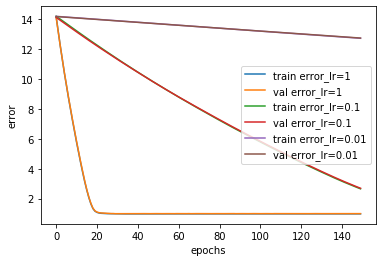

In [6]:
for lr in [1,0.1, 0.01]:
    train_error, test_error = cross_validate(Cross_Validation_data, lr)
    print("train_error", train_error[-1],"test error",test_error[-1])
    plt.xlabel('epochs')
    plt.ylabel('error')
    plt.plot(train_error,label='train error_lr={}'.format(lr))
    plt.plot(test_error,label='val error_lr={}'.format(lr))
    plt.legend()
#     plt.show()
plt.show()

In [7]:
Phi_X = poly.fit_transform(train_data[:,:-1])
Phi_XTEST = poly.fit_transform(TEST_data[:,:-1])
w, train_error, TEST_error = GradientDescent(Phi_X, train_data[:,-1:], Phi_XTEST, TEST_data[:,-1:], epochs=150, lr=1)
y_pred_TEST = Phi_XTEST.dot(w)

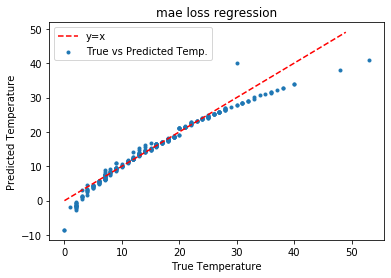

In [9]:
plt.title('mae loss regression')
plt.scatter(TEST_data[:,-1:], y_pred_TEST,label='True vs Predicted Temp.',marker='.')
a=np.arange(0,50,1)
plt.plot(a,a,label='y=x',color='r',linestyle='dashed')
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.legend()
plt.savefig('MAE_regressor.png')
plt.show()